In [33]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from slds.models.slds.model import *
from slds.models.slds.inference_ep import *
from slds.models.slds.inference_smf import *
from slds.models.lgssm.arma import ar2_lgssm
from slds.util import *

jax.config.update("jax_enable_x64", True)

In [34]:
key = jax.random.PRNGKey(2)

K = 3
A = jnp.array([
    [.98, .01, .01],
    [.01, .98, .01],
    [.01, .01, .98]])
a0 = jnp.ones(K) / 3

B, b, b0, C, c, Q, Q0, R = tree_stack([
    ar2_lgssm(alpha=.9, beta=.1, mu=-1., vz=.001, vz0=1., vx=.5**2),
    ar2_lgssm(alpha=.0, beta=1.0, mu=0., vz=.05, vz0=1., vx=.5**2),
    ar2_lgssm(alpha=.6, beta=.2, mu=1., vz=.01, vz0=1., vx=.5**2)], 0)

model = Slds(A, a0, B, b, b0, C, c, Q, Q0, R)

T = 250
s, z, x = slds_sample(key, model, T)

In [60]:
###############################################
# expectation propagation
###############################################
def _step(s, _):
    return slds_ep_inference_update(s, damping=.8), slds_ep_energy(s)

inference_state = slds_ep_inference_init(model, x)
inference_state, ep_energy = scan(_step, inference_state, jnp.arange(20))
posterior = slds_ep_inference_posterior(inference_state)

singleton_marginals = posterior.singleton_marginals
ep_s_mean, pz, pzz = vmap(gmm_meanparams)(singleton_marginals)

# just use first continuous state dimension
ep_z_mean = jnp.sum(pz, 1)[:,0] 
ep_z_sd = jnp.sqrt(jnp.sum(pzz - outer(pz, pz)/ep_s_mean[:,:,None,None], 1)[:,0,0])

In [61]:
###############################################
# structured mean-field VI
###############################################
def _step(s, _):
    return slds_smf_inference_update(s), slds_smf_elbo(s)

inference_state = slds_smf_inference_init(model, x)
inference_state, vi_elbo = scan(_step, inference_state, jnp.arange(20))
posterior = slds_smf_inference_posterior(inference_state)

discrete_marginals = dds_marginals(posterior.discrete_natparams)
continuous_marginals = lds_marginals(posterior.continuous_natparams)
vi_s_mean = vmap(discrete_meanparams)(discrete_marginals[0])
vi_z_mean, vi_z_V = vmap(gaussian_standardparams)(continuous_marginals[0])

# just use first continuous state dimension
vi_z_mean = vi_z_mean[:,0]
vi_z_sd = jnp.sqrt(vi_z_V[:,0,0])

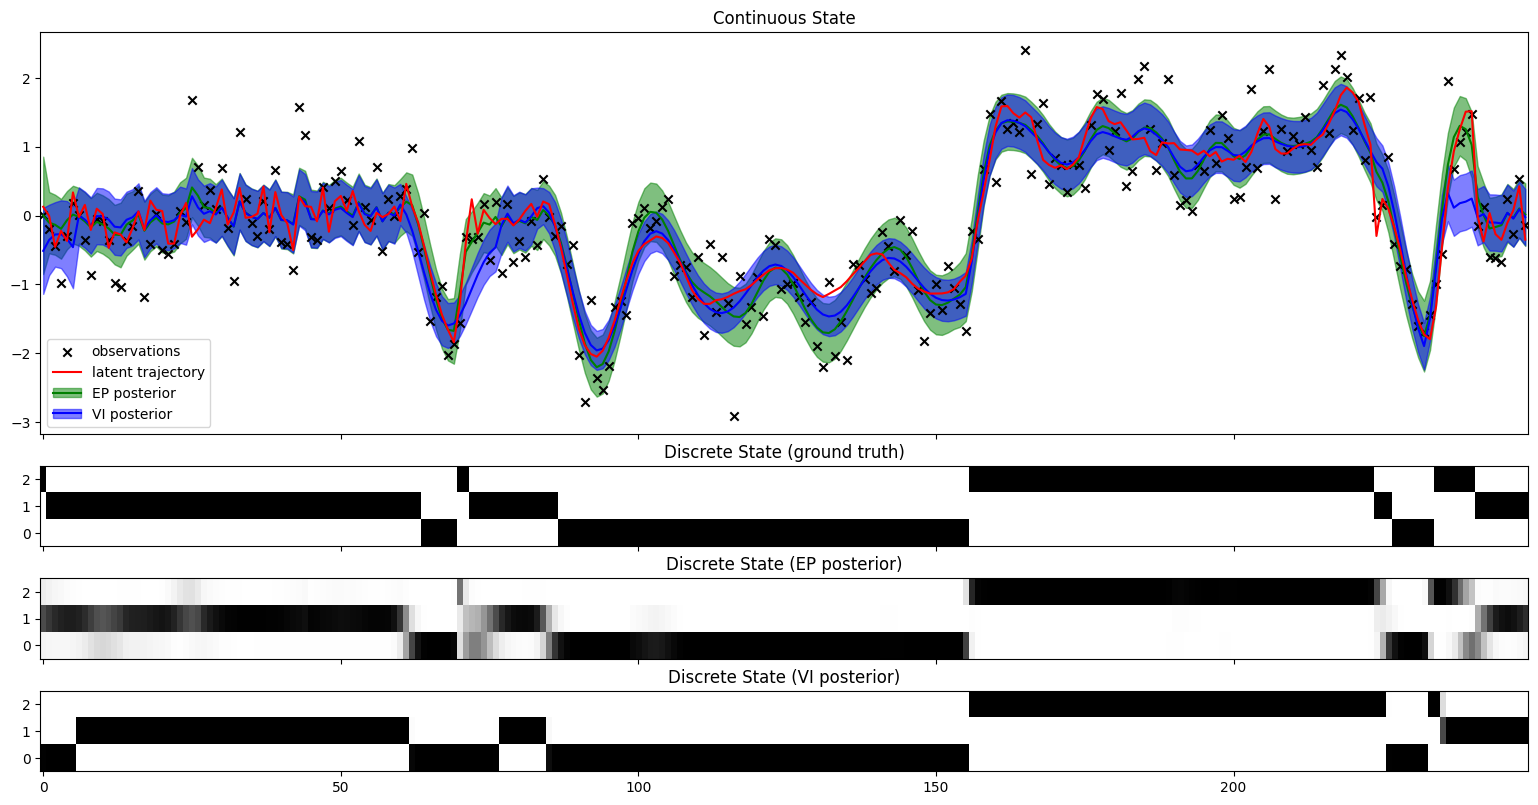

In [62]:
# plot continuous latent trajectory, observations
fig, ax = plt.subplots(4, 1, gridspec_kw={'height_ratios': [5, 1, 1, 1]}, sharex=True, figsize=[6.4*3, 4.8*2])
p_ep_mean = ax[0].plot(ep_z_mean, color='green')
p_ep_fill = ax[0].fill_between(jnp.arange(0, x.shape[0]), ep_z_mean - 2*ep_z_sd, ep_z_mean + 2*ep_z_sd, alpha=0.5, color='green')
p_smf_mean = ax[0].plot(vi_z_mean, color='blue')
p_smf_fill = ax[0].fill_between(jnp.arange(0, x.shape[0]), vi_z_mean - 2*vi_z_sd, vi_z_mean + 2*vi_z_sd, alpha=0.5, color='blue')
p_gt_latent = ax[0].plot(z[:,0], color='red')
p_gt_obs = ax[0].scatter(jnp.arange(0, x.shape[0]), x.squeeze(-1), marker='x', color='black')
ax[0].legend(
    [(p_gt_obs), p_gt_latent[0], (p_ep_mean[0], p_ep_fill), (p_smf_mean[0], p_smf_fill)],
    ['observations', 'latent trajectory', 'EP posterior', 'VI posterior'])
ax[0].set_title('Continuous State')

# plot discrete state ground truth
ax[1].imshow(jax.nn.one_hot(s, K, axis=-1).T, origin='lower', aspect='auto', interpolation='none', cmap='Greys')
ax[1].set_yticks([0,1,2])
ax[1].set_title('Discrete State (ground truth)')

# plot EP discrete state posterior
ax[2].imshow(ep_s_mean.T, origin='lower', aspect='auto', interpolation='none', cmap='Greys')
ax[2].set_yticks([0,1,2])
ax[2].set_title('Discrete State (EP posterior)');

# plot VI discrete state posterior
ax[3].imshow(vi_s_mean.T, origin='lower', aspect='auto', interpolation='none', cmap='Greys')
ax[3].set_yticks([0,1,2])
ax[3].set_title('Discrete State (VI posterior)')

plt.savefig('images/slds_plot.png', bbox_inches='tight');


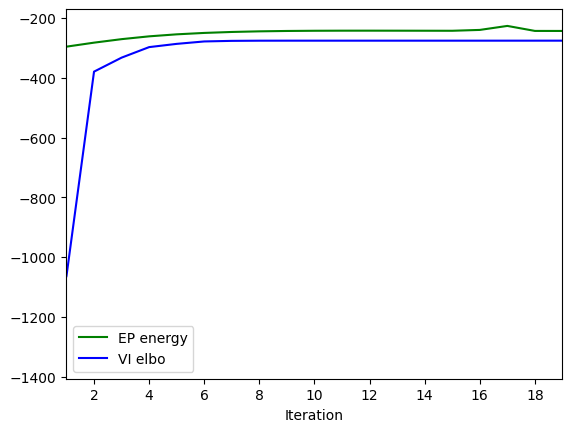

In [63]:
plt.plot(ep_energy, color='green')
plt.plot(vi_elbo, color='blue')
plt.xlim([1,19])
plt.xlabel('Iteration')
plt.legend(['EP energy', 'VI elbo'])